In [1]:
# Importing
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np

In [2]:

# Display images
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

# colored image
def plt_show0(img):
    b,g,r = cv2.split(img)
    img = cv2.merge([r, g, b])
    plt.imshow(img)
    plt.show()
    
# Gray Image
def plt_show(img):
    plt.imshow(img,cmap='gray')
    plt.show()

# After gaussian blur
def gray_guss(image):
    image = cv2.GaussianBlur(image, (3, 3), 0)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

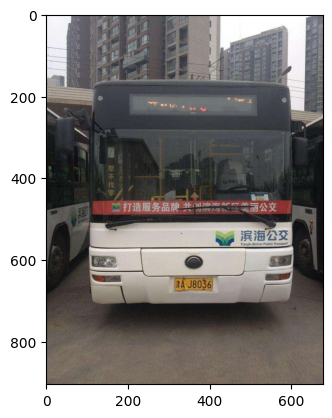

In [3]:
# Read the image
origin_image = cv2.imread('./image/test4.png')
plt_show0(origin_image)

In [4]:
# Extract the plate region from the source images
def get_carLicense_img(image):
    gray_image = gray_guss(image)
    Sobel_x = cv2.Sobel(gray_image, cv2.CV_16S, 1, 0)
    absX = cv2.convertScaleAbs(Sobel_x)
    image = absX
    ret, image = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)
    kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 5))
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernelX,iterations = 3)
    kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
    kernelY = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 19))
    image = cv2.dilate(image, kernelX)
    image = cv2.erode(image, kernelX)
    image = cv2.erode(image, kernelY)
    image = cv2.dilate(image, kernelY)
    image = cv2.medianBlur(image, 15)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for item in contours:
        rect = cv2.boundingRect(item)
        x = rect[0]
        y = rect[1]
        weight = rect[2]
        height = rect[3]
        if (weight > (height * 2.5)) and (weight < (height * 4)):
            image = origin_image[y:y + height, x:x + weight]
            return image

Successfully extract the license plate image

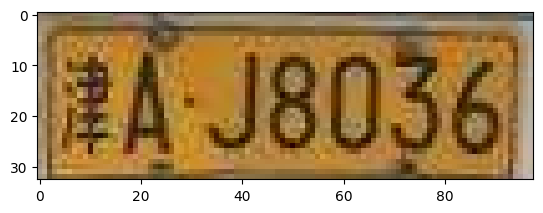

True

In [5]:
image = origin_image.copy()
carLicense_image = get_carLicense_img(image)
plt_show0(carLicense_image)
cv2.imwrite('./car_license/test4.png', carLicense_image)

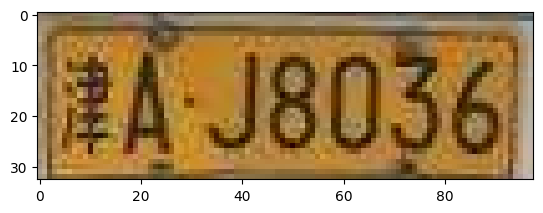

In [6]:
# Load Image
rawImage = cv2.imread("./car_license/test4.png")
plt_show0(rawImage)

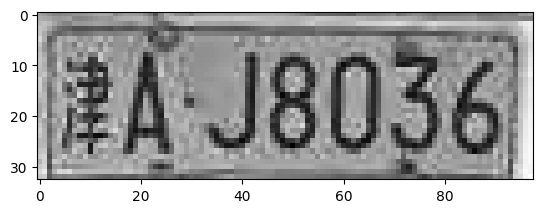

In [7]:
# RGB to gray
image = rawImage.copy()
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt_show(gray_image)

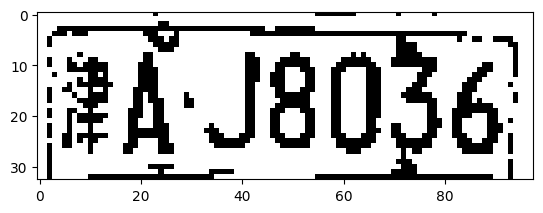

In [8]:
# threshold
ret, image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)
plt_show(image)

In [9]:
image.shape # 47 rows，170 columns
rows = image.shape[0]
cols = image.shape[1]
print(rows,cols)

33 98


In [10]:
# binarize the image and count the black pixel values(0) of each row
hd = []
for row in range(rows):
    res = 0
    for col in range(cols):
        if image[row][col] == 0:
            res = res+1
    hd.append(res)
len(hd)
max(hd)

62

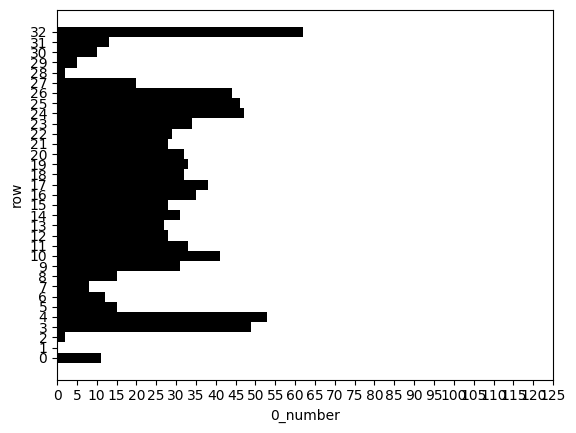

In [11]:
# Plot the histogram
y = [y for y in range(rows)]
x = hd
plt.barh(y,x,color='black',height=1)
# Set x,y Axis
plt.xlabel('0_number')
plt.ylabel('row')
# Scale and precision
plt.xticks([x for x in range(0,130,5)])
plt.yticks([y for y in range(0,rows,1)])

plt.show()

In [12]:
x = range(int(rows/2),2,-1)
x = [*x]
x

[16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]

In [13]:
# Looking for trough crest to eliminate the boundaries effect
mean = sum(hd[0:int(rows/2)])/(int(rows/2)+1)
mean
region = []
for i in range(int(rows/2),2,-1): # Starting from row three since first two are boundaries
    if hd[i]<mean:
        region.append(i)
        break
for i in range(int(rows/2),rows): # Starting from row three since first two are boundaries
    if hd[i]<mean:
        region.append(i)
        break
region

[8, 27]

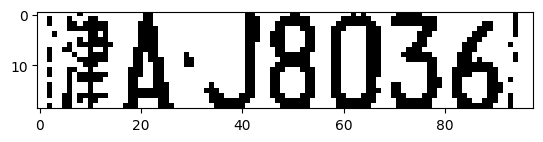

In [14]:
image1 = image[region[0]:region[1],:] # Row
plt_show(image1)

In [15]:
image11 = image1.copy()
image11.shape # 47rows，170cols
rows = image11.shape[0]
cols = image11.shape[1]
print(rows,cols)

19 98


In [16]:
# Count black value(0) for each col
hd1 = []
for col in range(cols):
    res = 0
    for row in range(rows):
        if image11[row][col] == 0:
            res = res+1
    hd1.append(res)
len(hd1)
max(hd1)

18

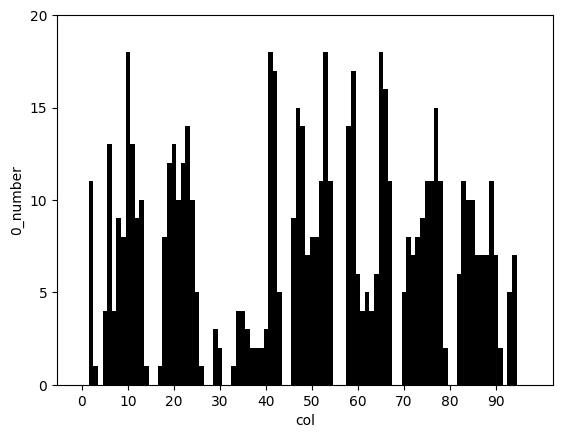

In [17]:
# Histogram
y = hd1 # spot num
x = [x for x in range(cols)] # columns number
plt.bar(x,y,color='black',width=1)
# x,y axis
plt.xlabel('col')
plt.ylabel('0_number')
# scale and precison
plt.xticks([x for x in range(0,cols,10)])
plt.yticks([y for y in range(0,max(hd1)+5,5)])

plt.show()

In [18]:
mean = sum(hd1)/len(hd1)
# Simple filter
for i in range(cols):
    if hd1[i] < mean/4:
        hd1[i] = 0

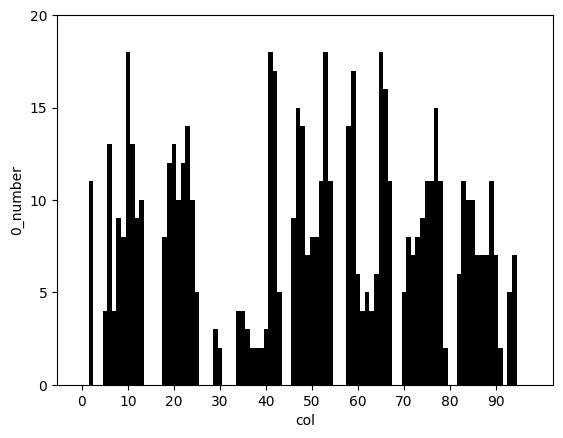

In [19]:
# Histogram
y = hd1 # 点个数
x = [x for x in range(cols)] # col
plt.bar(x,y,color='black',width=1)
plt.xlabel('col')
plt.ylabel('0_number')
plt.xticks([x for x in range(0,cols,10)])
plt.yticks([y for y in range(0,max(hd1)+5,5)])

plt.show()

In [20]:
# List all the column num whose value are not 0
region1 = []
reg = []
for i in range(cols-1):
    if hd1[i]==0 and hd1[i+1] != 0:
        reg.append(i)
    if hd1[i]!=0 and hd1[i+1] == 0:
        reg.append(i+2)
    if len(reg) == 2:
        if (reg[1]-reg[0])>5: #filter some columns
            region1.append(reg) 
            reg = []
        else:
            reg = []
region1

[[4, 15], [17, 27], [33, 45], [45, 56], [57, 69], [69, 81], [81, 93]]

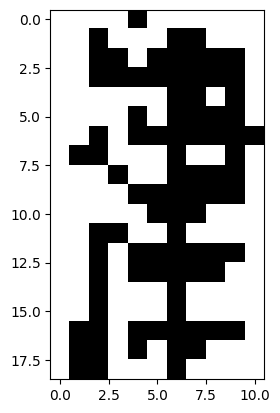

In [21]:
# test
image2 = image1[:,region1[0][0]:region1[0][1]]
plt_show(image2)

In [22]:
# 为了使字符之间还是存在空格,定义一个2像素白色的区域
import numpy as np
white = []
for i in range(rows*2):
    white.append(255)
white = np.array(white)
white = white.reshape(rows,2)
white.shape

(19, 2)

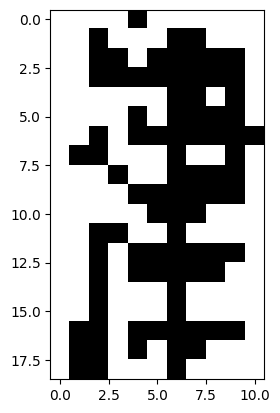

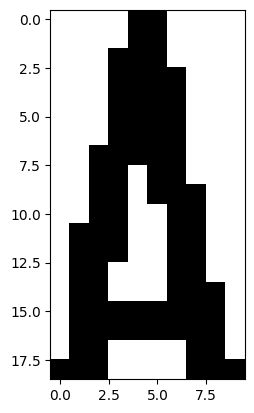

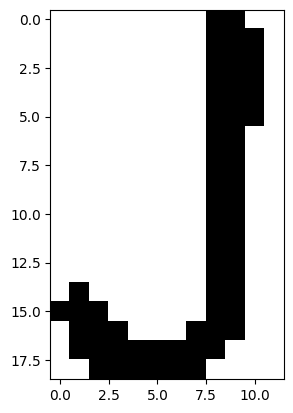

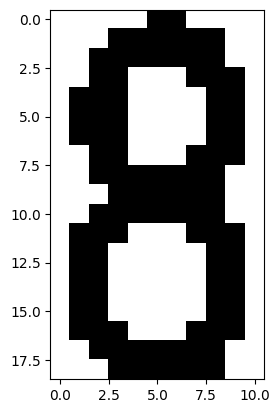

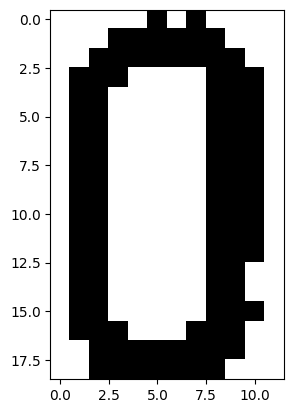

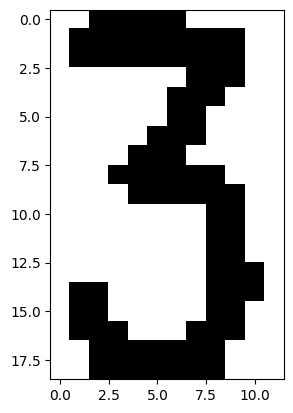

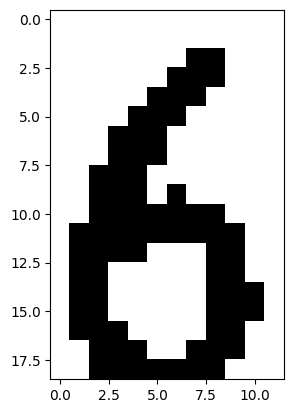

In [23]:
#  遍历所有区域,保存字符图片到列表
p = []
for r in region1:
    r = image1[:,r[0]:r[1]]
    plt_show(r)
    p.append(r)
    p.append(white)
    

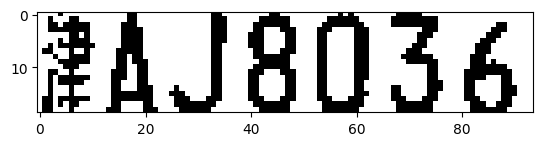

In [24]:
# 将字符图片列表拼接为一张图
image2 = np.hstack(p)
plt_show(image2)

Successfully Segmenting the characters

In [25]:
# Seg pictures and save the chars
print(region)
print(region1)


[8, 27]
[[4, 15], [17, 27], [33, 45], [45, 56], [57, 69], [69, 81], [81, 93]]


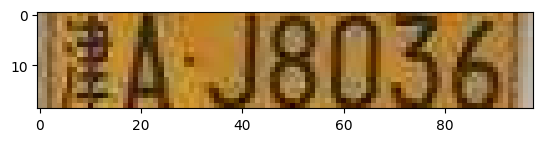

In [26]:
v_image = rawImage[region[0]:region[1],:]
plt_show0(v_image)

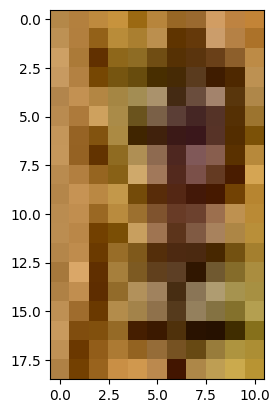

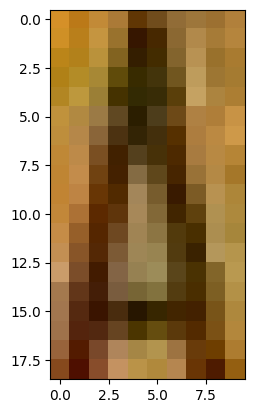

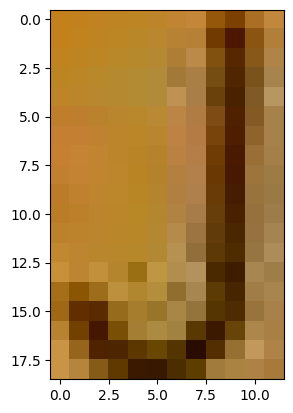

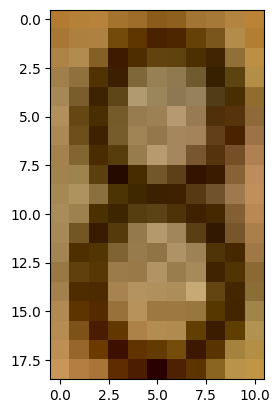

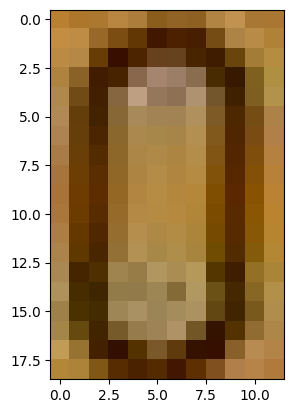

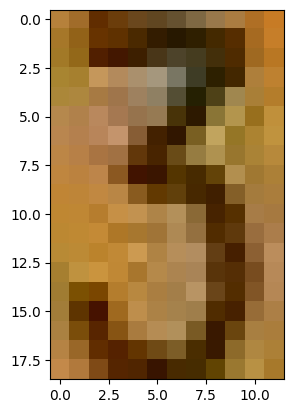

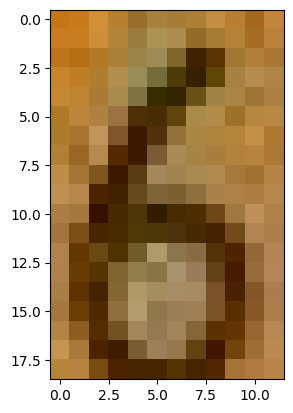

In [27]:
i = 1
for reg in region1:
    h_image = v_image[:,reg[0]:reg[1]]
    plt_show0(h_image)
    cv2.imwrite('./words/test4_'+str(i)+'.png', h_image)
    i = i+1

C:\Users\lotus\AppData\Local\Temp\ipykernel_60352\1673626815.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,8,i+1)


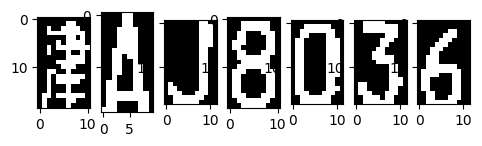

In [28]:
word_images = []
for i in range(1,8):
    word =  cv2.imread('./words/test4_'+str(i)+'.png',0)
    ret, word = cv2.threshold(word, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    word_images.append(word)
word_images
plt.imshow(word_images[0],cmap='gray')    
for i,j in enumerate(word_images):  
    plt.subplot(1,8,i+1)
    plt.imshow(word_images[i],cmap='gray')
plt.show()

In [29]:
import os
# Prepare Templates
template = ['0','1','2','3','4','5','6','7','8','9',
            'A','B','C','D','E','F','G','H','J','K','L','M','N','P','Q','R','S','T','U','V','W','X','Y','Z',
            '藏','川','鄂','甘','赣','贵','桂','黑','沪','吉','冀','津','晋','京','辽','鲁','蒙','闽','宁',
            '青','琼','陕','苏','皖','湘','新','渝','豫','粤','云','浙']

# Read all the pictures under this folder
def read_directory(directory_name):
    referImg_list = []
    for filename in os.listdir(directory_name):
        referImg_list.append(directory_name + "/" + filename)
    return referImg_list

# Match the first Chinese Character
def get_chinese_words_list():
    chinese_words_list = []
    for i in range(34,64):
        c_word = read_directory('./refer1/'+ template[i])
        chinese_words_list.append(c_word)
    return chinese_words_list
chinese_words_list = get_chinese_words_list()

# Match the alphabet
def get_eng_words_list():
    eng_words_list = []
    for i in range(10,34):
        e_word = read_directory('./refer1/'+ template[i])
        eng_words_list.append(e_word)
    return eng_words_list
eng_words_list = get_eng_words_list()

# Match the following numbers
def get_eng_num_words_list():
    eng_num_words_list = []
    for i in range(0,34):
        word = read_directory('./refer1/'+ template[i])
        eng_num_words_list.append(word)
    return eng_num_words_list
eng_num_words_list = get_eng_num_words_list()


# Read the template address and ,atch
def template_score(template,image):
    template_img=cv2.imdecode(np.fromfile(template,dtype=np.uint8),1)
    template_img = cv2.cvtColor(template_img, cv2.COLOR_RGB2GRAY)
    ret, template_img = cv2.threshold(template_img, 0, 255, cv2.THRESH_OTSU)
#     height, width = template_img.shape
#     image_ = image.copy()
#     image_ = cv2.resize(image_, (width, height))
    image_ = image.copy()
    height, width = image_.shape
    template_img = cv2.resize(template_img, (width, height))
    result = cv2.matchTemplate(image_, template_img, cv2.TM_CCOEFF)
    return result[0][0]

In [30]:
def template_matching(word_images):
    results = []
    for index,word_image in enumerate(word_images):
        if index==0:
            best_score = []
            for chinese_words in chinese_words_list:
                score = []
                for chinese_word in chinese_words:
                    result = template_score(chinese_word,word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            # print(template[34+i])
            r = template[34+i]
            results.append(r)
            continue
        if index==1:
            best_score = []
            for eng_word_list in eng_words_list:
                score = []
                for eng_word in eng_word_list:
                    result = template_score(eng_word,word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            # print(template[10+i])
            r = template[10+i]
            results.append(r)
            continue
        else:
            best_score = []
            for eng_num_word_list in eng_num_words_list:
                score = []
                for eng_num_word in eng_num_word_list:
                    result = template_score(eng_num_word,word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            # print(template[i])
            r = template[i]
            results.append(r)
            continue
    return results

In [31]:
word_images_ = word_images.copy()
result = template_matching(word_images_)
result

['津', 'A', 'J', '8', '0', '3', '6']

In [32]:
height,weight = origin_image.shape[0:2]
print(height)
print(weight)

905
678


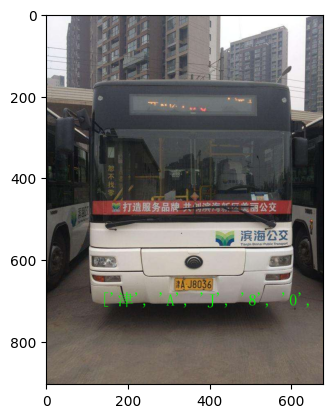

In [33]:
image = origin_image.copy()
from PIL import Image,ImageDraw,ImageFont
import numpy as np
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
draw = ImageDraw.Draw(image)
#Character position
position = (int(0.2*weight), int(0.75*height))
#Font use the font size in the windows  
font = ImageFont.truetype(r"C:/Windows/Fonts/simsun.ttc", 40)
#rgd format color
fill = (0,255,0)
draw.text(position,str(result),fill,font)
image = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)
plt_show0(image)